In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
train = pd.read_csv('/kaggle/input/predict-volcanic-eruptions-ingv-oe/train.csv')
train.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


### Used fillna(0) to replace NaN values
### I decided not to remove outliers because they could be the tell-tale sign for a volanco erupting.
### I took the log of the values because the standard deviation was too large for some of the sensors.
### I also could not perform most of the techniques from W9 because they simply do not apply to sensor data. For example, there is no noisy data, categorical values for one-hot encodings, and dates.

### I created 8 new features to compress each train csv. The 8 new features are: mean, standard deviation, min, max, median, range, first quartile, third quartile, and inter-quartile range.

### I created a new set of features that is based on the mean, median, and sum of the sensor values per row called sensor_all_*. 

Got the below from: https://www.kaggle.com/altprof/basic-feature-engineering-and-modeling

In [ ]:
def df_parallelize_run(func, t_split, cores=4):
    num_cores = np.min([cores, len(t_split)])
    pool = Pool(processes=num_cores)
    df = pd.concat(pool.starmap(func, t_split), axis=0)
    pool.close()
    pool.join()
    
    return df

def get_basic_features(df, direct='train'):
    
    result = pd.DataFrame(dtype=np.float32)
    result['segment_id'] = df['segment_id']
    result['time_to_eruption'] = df['time_to_eruption']
    result.set_index('segment_id', inplace=True)
    qwer=df['segment_id']
    
    for ids in qwer:
        
        f = pd.read_csv(f'/kaggle/input/predict-volcanic-eruptions-ingv-oe/{direct}/{ids}.csv')
        f['sensor_allAvg'] = f.mean(1)
        f['sensor_allSum'] = f.sum(1)
        f['sensor_allMed'] = f.median(1)
                                                           
        for sensor in f.columns:

            data=f[sensor].fillna(0)                                 

            data = np.asarray(data)
            data = np.log((data-np.min(data)+1))
            mean = np.mean(data)                        # mean
            std = np.std(data)                          # std
            min_ = np.min(data)                         # minimum
            max_ = np.max(data)                         # maximum
            med = np.median(data)                       # median
            ran = max_ - min_                           # range
            q1, q3 = np.quantile(data, q=[0.25, 0.75])  # 1st & 3rd quartile
            iqr = q3 - q1                               # IQR

            result.loc[ids, f'{sensor}_mean'] = mean
            result.loc[ids, f'{sensor}_std'] = std
            result.loc[ids, f'{sensor}_med'] = med
            result.loc[ids, f'{sensor}_min'] = min_
            result.loc[ids, f'{sensor}_max'] = max_
            result.loc[ids, f'{sensor}_ran'] = ran
            result.loc[ids, f'{sensor}_q1'] = q1
            result.loc[ids, f'{sensor}_q3'] = q3
            result.loc[ids, f'{sensor}_iqr'] = iqr
            
    return result

In [ ]:
N_CORES = 4
chunk_size = train.shape[0] // N_CORES
splits_train = [train[:chunk_size], train[chunk_size:2*chunk_size], train[2*chunk_size:3*chunk_size], train[3*chunk_size:]]

In [ ]:
%%time
train_df = df_parallelize_run(get_basic_features, 
                              [(chunk, 'train') for chunk in splits_train],
                              N_CORES)

CPU times: user 303 ms, sys: 153 ms, total: 457 ms
Wall time: 6min 3s


In [ ]:
train_df.head()

,time_to_eruption,sensor_1_mean,sensor_1_std,sensor_1_med,sensor_1_min,sensor_1_max,sensor_1_ran,sensor_1_q1,sensor_1_q3,sensor_1_iqr,...,sensor_allSum_iqr,sensor_allMed_mean,sensor_allMed_std,sensor_allMed_med,sensor_allMed_min,sensor_allMed_max,sensor_allMed_ran,sensor_allMed_q1,sensor_allMed_q3,sensor_allMed_iqr
segment_id,,,,,,,,,,,,,,,,,,,,,
1136037770,12262005,7.233328,0.236131,7.259820,0.0,7.928406,7.928406,7.109062,7.390799,0.281736,...,0.307085,6.696098,0.251448,6.723832,0.0,7.436028,7.436028,6.546785,6.876609,0.329823
1969647810,32739612,7.577003,0.252974,7.603898,0.0,8.343554,8.343554,7.462215,7.730175,0.267960,...,0.251317,6.739262,0.241667,6.760936,0.0,7.477293,7.477293,6.597214,6.906254,0.309040
1895879680,14965999,6.993968,0.238551,7.017506,0.0,7.724888,7.724888,6.865891,7.149132,0.283241,...,0.230782,6.267030,0.304321,6.307896,0.0,7.050026,7.050026,6.097825,6.481407,0.383582
2068207140,26469720,6.909850,0.237555,6.933423,0.0,7.731931,7.731931,6.790097,7.061334,0.271237,...,0.281395,6.074326,0.279673,6.110358,0.0,6.808708,6.808708,5.916067,6.273349,0.357281
192955606,31072429,7.055827,0.242568,7.082549,0.0,7.742836,7.742836,6.927558,7.215975,0.288417,...,0.259843,6.443919,0.234927,6.469595,0.0,7.176424,7.176424,6.299358,6.613682,0.314325


In [ ]:
train_df.to_csv('/kaggle/working/volcano.csv')

### I removed all columns where the number of unique values is 1.
### I log transformed 'time_to_eruption' for consistency.

In [ ]:
df = pd.read_csv('/kaggle/working/volcano.csv')
df['time_to_eruption'] = np.log((df['time_to_eruption']-np.min(df['time_to_eruption'])+1))
a = df.nunique()
to_del = list(a[a<2].index)
df.drop(to_del, axis=1, inplace=True)
df.head()

,segment_id,time_to_eruption,sensor_1_mean,sensor_1_std,sensor_1_med,sensor_1_max,sensor_1_ran,sensor_1_q1,sensor_1_q3,sensor_1_iqr,...,sensor_allSum_q3,sensor_allSum_iqr,sensor_allMed_mean,sensor_allMed_std,sensor_allMed_med,sensor_allMed_max,sensor_allMed_ran,sensor_allMed_q1,sensor_allMed_q3,sensor_allMed_iqr
0,1136037770,16.321506,7.233328,0.236131,7.259820,7.928406,7.928406,7.109062,7.390799,0.281736,...,9.043485,0.307085,6.696098,0.251448,6.723832,7.436028,7.436028,6.546785,6.876609,0.329823
1,1969647810,17.303905,7.577003,0.252974,7.603898,8.343554,8.343554,7.462215,7.730175,0.267960,...,9.316285,0.251317,6.739262,0.241667,6.760936,7.477293,7.477293,6.597214,6.906254,0.309040
2,1895879680,16.520874,6.993968,0.238551,7.017506,7.724888,7.724888,6.865891,7.149132,0.283241,...,9.074381,0.230782,6.267030,0.304321,6.307896,7.050026,7.050026,6.097825,6.481407,0.383582
3,2068207140,17.091276,6.909850,0.237555,6.933423,7.731931,7.731931,6.790097,7.061334,0.271237,...,8.686852,0.281395,6.074326,0.279673,6.110358,6.808708,6.808708,5.916067,6.273349,0.357281
4,192955606,17.251630,7.055827,0.242568,7.082549,7.742836,7.742836,6.927558,7.215975,0.288417,...,8.912518,0.259843,6.443919,0.234927,6.469595,7.176424,7.176424,6.299358,6.613682,0.314325


In [ ]:
fordf=df.drop(['time_to_eruption'],1)
fordf=fordf.drop(['segment_id'],1)
fordf.head()

,sensor_1_mean,sensor_1_std,sensor_1_med,sensor_1_max,sensor_1_ran,sensor_1_q1,sensor_1_q3,sensor_1_iqr,sensor_2_mean,sensor_2_std,...,sensor_allSum_q3,sensor_allSum_iqr,sensor_allMed_mean,sensor_allMed_std,sensor_allMed_med,sensor_allMed_max,sensor_allMed_ran,sensor_allMed_q1,sensor_allMed_q3,sensor_allMed_iqr
0,7.233328,0.236131,7.259820,7.928406,7.928406,7.109062,7.390799,0.281736,8.548141,0.143071,...,9.043485,0.307085,6.696098,0.251448,6.723832,7.436028,7.436028,6.546785,6.876609,0.329823
1,7.577003,0.252974,7.603898,8.343554,8.343554,7.462215,7.730175,0.267960,8.346498,0.168978,...,9.316285,0.251317,6.739262,0.241667,6.760936,7.477293,7.477293,6.597214,6.906254,0.309040
2,6.993968,0.238551,7.017506,7.724888,7.724888,6.865891,7.149132,0.283241,8.714737,0.151309,...,9.074381,0.230782,6.267030,0.304321,6.307896,7.050026,7.050026,6.097825,6.481407,0.383582
3,6.909850,0.237555,6.933423,7.731931,7.731931,6.790097,7.061334,0.271237,7.935252,0.165281,...,8.686852,0.281395,6.074326,0.279673,6.110358,6.808708,6.808708,5.916067,6.273349,0.357281
4,7.055827,0.242568,7.082549,7.742836,7.742836,6.927558,7.215975,0.288417,0.000000,0.000000,...,8.912518,0.259843,6.443919,0.234927,6.469595,7.176424,7.176424,6.299358,6.613682,0.314325


### Dimensionality Reduction: RandomForestRegressor

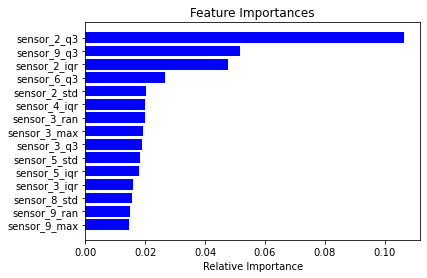

In [ ]:
model = RandomForestRegressor(random_state=1)
fordf=pd.get_dummies(fordf)
model.fit(fordf,df.time_to_eruption)
features = fordf.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
featureDict=dict(reversed(sorted(zip(model.feature_importances_, fordf.columns.values))))

### Dimensionality Reduction: PCA

In [ ]:
pca = PCA()
x_pca = pca.fit_transform(fordf)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,-5.136469,12.998274,8.907183,-2.338884,-1.322205,0.256721,0.380108,0.030032,-0.607223,-0.798725,...,6.771657e-17,4.884416e-15,-5.980345e-17,5.117412e-17,3.999026e-16,1.047112e-15,2.049769e-15,-1.032957e-15,-6.443322e-16,6.841988e-16
1,-2.514846,-1.409069,-3.551575,-0.516364,-1.259713,-0.265664,-1.226148,-0.726613,-0.737629,0.248497,...,5.389989e-16,-1.530992e-15,-2.634051e-16,-1.895660e-16,-1.022285e-15,-4.096543e-16,-8.391354e-16,5.176292e-16,-8.344523e-17,-4.005140e-16
2,-4.383630,12.427184,9.319439,-4.332025,-2.247063,1.187267,0.982086,-0.285702,-0.645610,-0.038303,...,-5.640579e-16,-2.063331e-15,2.636402e-17,-3.534093e-16,9.332234e-17,-1.273378e-16,1.539464e-16,1.148110e-15,-1.056388e-15,8.676972e-17
3,-0.956740,-2.496855,-0.620681,-0.439212,-4.090949,1.161100,-0.749651,-0.550821,-0.448972,-1.067393,...,-2.286758e-17,-1.078351e-15,-9.099083e-16,1.041147e-15,4.201316e-16,1.493673e-15,-2.774572e-17,9.514868e-16,-1.191893e-15,9.037073e-17
4,15.709955,2.106302,-0.181645,9.667426,-1.051813,2.919072,-2.074440,-0.223968,-0.118941,0.335110,...,-1.001466e-15,9.213431e-16,-6.545145e-16,4.748740e-16,1.805883e-16,-9.877404e-16,7.372466e-16,-1.321733e-15,-1.300806e-16,7.135793e-16


In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance[:30]

array([4.30572129e-01, 1.87323794e-01, 1.67278180e-01, 7.13713477e-02,
       5.44810469e-02, 2.99880629e-02, 2.55989566e-02, 1.24249224e-02,
       1.00219449e-02, 5.37306091e-03, 2.45137338e-03, 1.12283603e-03,
       4.15345105e-04, 3.73506776e-04, 1.78378946e-04, 1.36889618e-04,
       1.06696561e-04, 8.71317423e-05, 8.04126807e-05, 6.18874052e-05,
       5.68501366e-05, 5.24251314e-05, 4.95975941e-05, 4.61081260e-05,
       4.05850001e-05, 3.78185717e-05, 3.48441798e-05, 3.38566484e-05,
       2.89309508e-05, 2.55274704e-05])

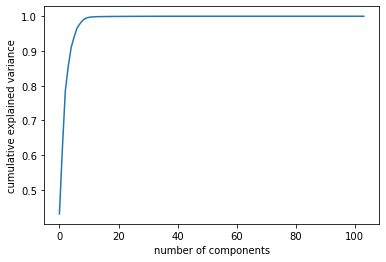

In [ ]:
np.cumsum(pca.explained_variance_ratio_)
plt.plot(list(range(len(explained_variance))), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
x_pca['target']=df['segment_id'].values

### Unsupervised Learning: KMeans

In [ ]:
x=x_pca[list(range(0, 12))]
x=np.array(x)
for i in range(3,12):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(x)
  q=kmeans.predict(x)
  print('# of Clusters: ',i)
  print(silhouette_score(x,q))

# of Clusters:  3
0.5064071974123245
# of Clusters:  4
0.5705271572137516
# of Clusters:  5
0.6018241396878173
# of Clusters:  6
0.5825779364293885
# of Clusters:  7
0.608435784267629
# of Clusters:  8
0.6221955672575636
# of Clusters:  9
0.40979446496426475
# of Clusters:  10
0.417998608193327
# of Clusters:  11
0.4274504046777354


According to KMeans, the best number of clusters to use is 8.

### Unsupervised Learning: MeanShift

0.6672025719394913


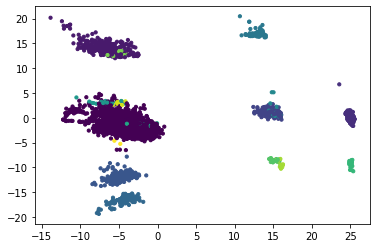

In [ ]:
ms = MeanShift()
ms.fit(x) 
plt.scatter(x[:,0], x[:,1],s=10, c=ms.predict(x))
print(silhouette_score(x,ms.predict(x)))

### Supervised Learning: SVR & LinearRegression

In [ ]:
featureList=list(featureDict.values())

In [ ]:
y = np.array(df['time_to_eruption'])
X=np.array(df[featureList])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
svrs = [SVR(kernel='linear', gamma='scale'), SVR(kernel='poly', gamma='scale'), 
        SVR(kernel='rbf', gamma='scale'), SVR(kernel='sigmoid', gamma='scale')]

for model in svrs:
    model.fit(X_train,y_train)
    print(model.score(X_test, y_test))

0.2920401306526932
0.343316905772867
0.3218063408593179
-2.143373216015822


score:  0.34445953404988006
Mean Absolute Error: 0.544628180393055
Mean Squared Error: 0.7419239677939968
Root Mean Squared Error: 0.8613500843408544
R-squared Error: 0.34445953404988006
Mean Absolute Percentage Error (MAPE): 54.46
Accuracy: 45.54


Text(0, 0.5, 'Pred')

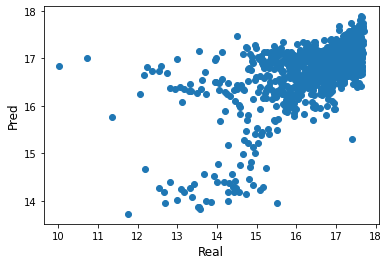

In [ ]:
svr=SVR(kernel='poly', gamma='scale',epsilon=0.0000001)
svr.fit(X_train,y_train)
print('score: ',svr.score(X_test, y_test))
y_pred = svr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))
mape = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
plt.figure(0)
plt.scatter(y_test,y_pred)
plt.xlabel('Real', fontsize=12)
plt.ylabel('Pred', fontsize=12)

The best SVR has a score of 0.34 using a poly kernel.

score:  0.2839097410950635
Mean Absolute Error: 0.6271089803411968
Mean Squared Error: 0.8104526780285846
Root Mean Squared Error: 0.900251452666745
R-squared Error: 0.2839097410950635
Mean Absolute Percentage Error (MAPE): 62.71
Accuracy: 37.29


Text(0, 0.5, 'Pred')

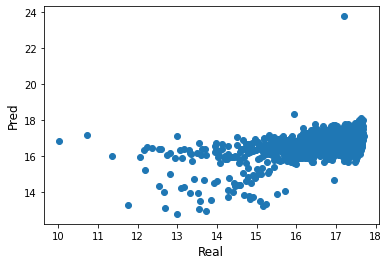

In [ ]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('score: ',regressor.score(X_test, y_test))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))
mape = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
plt.figure(0)
plt.scatter(y_test,y_pred)
plt.xlabel('Real', fontsize=12)
plt.ylabel('Pred', fontsize=12)

Linear Regression had a score of 0.28, and it has lower metrics than the SVR

### Advanced Model: Neural Network
I could not get tfv1 to work, so I could not use the notebook.
Instead I used this link: https://www.tensorflow.org/tutorials/keras/regression to build the model.

In [ ]:
model = keras.Sequential([
  normalizer,
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

model.compile(loss='mean_absolute_error',
            optimizer=tf.keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 104)               209       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                6720      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 11,154
Trainable params: 10,945
Non-trainable params: 209
_________________________________________________________________


In [ ]:
%%time

history = model.fit(
    X_train, y_train, 
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 13.5 s, sys: 1.98 s, total: 15.4 s
Wall time: 10.9 s


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [time_to_eruption]')
  plt.legend()
  plt.grid(True)

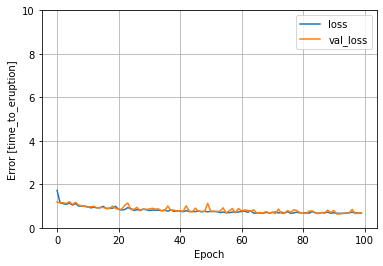

In [ ]:
plot_loss(history)

In [ ]:
test_results = model.evaluate(X_test, y_test, verbose=0)
print('Mean Absolute Error:', test_results)

Mean Absolute Error: 0.6017389605816146


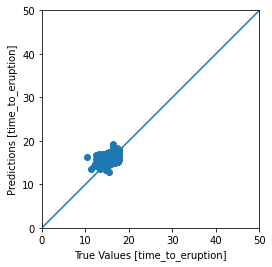

In [ ]:
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [time_to_eruption]')
plt.ylabel('Predictions [time_to_eruption]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

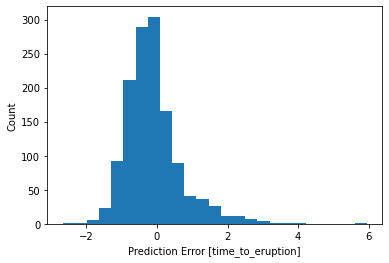

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [time_to_eruption]')
_ = plt.ylabel('Count')